In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import *
from statsmodels.graphics.tsaplots import *
from catboost import *
from sklearn.model_selection import *
from sklearn.metrics import *
from sklearn.datasets import load_diabetes
from sklearn.model_selection import *
from sklearn.linear_model import *
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import *
from sklearn.ensemble import *
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.svm import *
from sklearn.neighbors import *
from sklearn.neural_network import *
from sklearn.metrics import *
import pickle
import tensorflow as tf
import shap
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import *
import os

# 敏感性分析需要禁用v2_behavior
# tf.compat.v1.disable_v2_behavior()

forceCpu = False
# 使用CPU
if forceCpu:
    cpu = tf.config.list_physical_devices("CPU")
    tf.config.set_visible_devices(cpu)
    print(tf.config.list_logical_devices())

# 动态显存
if not forceCpu:
    physical_devices = tf.config.list_physical_devices('GPU')
    try:
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
    except:
        print('Invalid device or cannot modify virtual devices once initialized')

plt.rcParams['font.sans-serif'] = ['SimHei']  # 黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决无法显示符号的问题
palette = 'deep'
sns.set(font='SimHei', font_scale=1.2, style='whitegrid', palette=palette)  # 解决Seaborn中文显示问题

D:\Users\win\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
rawData = pd.read_excel('../../../preprocess/2022左侧填充-物流网络历史货量数据.xlsx')
rawData = pd.melt(rawData, id_vars=['场地1', '场地2'], value_name='货量', var_name='日期')
rawData.head()

,场地1,场地2,日期,货量
0,DC1,DC8,2022-01-01,3
1,DC10,DC12,2022-01-01,73
2,DC10,DC13,2022-01-01,2
3,DC10,DC14,2022-01-01,2759
4,DC10,DC17,2022-01-01,2


In [3]:

filterSize = 5


def getxy(mask=None):
    targetKey = '货量'
    # 对场地进行编码

    df = rawData.copy()
    if mask is not None:
        df = df[(df['场地1'] == mask[0]) & (df['场地2'] == mask[1])].reset_index(drop=True)
    df['场地1'] = df['场地1'].str.replace('DC', '')
    df['场地1'] = df['场地1'].astype('int64')
    df['场地2'] = df['场地2'].str.replace('DC', '')
    df['场地2'] = df['场地2'].astype('int64')

    df['日期'] = pd.to_datetime(df['日期'])
    df['日期'] = df['日期'] - df['日期'].min()
    df['日期'] = df['日期'].apply(lambda x: x.days)

    df['货量'] = np.log(df['货量'])
    # return df.drop(targetKey, axis=1), df[targetKey], df

    grouped = df.groupby(['场地1', '场地2']).size().reset_index(name='count')
    merged = pd.merge(df, grouped, on=['场地1', '场地2'], how='left').reset_index(drop=True)
    ltSize = merged[merged['count'] < filterSize]
    print(f'总行数有：{df.shape}')
    print(f'数据小于{filterSize}的行数有：{ltSize.shape}')
    filtered = merged[merged['count'] >= filterSize]
    filtered = filtered.drop('count', axis=1)
    print(f'清洗后数量：{filtered.shape}')
    return filtered.drop(targetKey, axis=1), filtered[targetKey], filtered


# 读入数据
_, _, data = getxy(('DC14', 'DC10'))
data

总行数有：(365, 4)
数据小于5的行数有：(0, 5)
清洗后数量：(365, 4)


,场地1,场地2,日期,货量
0,14,10,0,10.460758
1,14,10,1,11.013551
2,14,10,2,10.468773
3,14,10,3,10.429635
4,14,10,4,9.940398
...,...,...,...,...
360,14,10,360,10.249167
361,14,10,361,10.529052
362,14,10,362,10.065564
363,14,10,363,9.918918


In [4]:
# 将数据处理成模型可接受的形式
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        # a = dataset[i:(i + look_back), :-1]
        # 自回归
        a = dataset[i:(i + look_back), :]
        dataX.append(a)
        dataY.append(dataset[i + look_back, -1])
    return np.array(dataX), np.array(dataY)


look_back = filterSize - 1
trainX, trainY = [], []
train_x, train_y = create_dataset(data.values, look_back)
trainX.append(train_x)
trainY.append(train_y)

trainX, trainY = np.concatenate(trainX), np.concatenate(trainY)
ratio = int(len(trainX) * 0.9)
# 训练集占比弄满，不然后面一段时间数据吃不到
trainX, testX, trainY, testY = trainX[:], trainX[ratio:], trainY[:], trainY[ratio:]

print(f'trainX.shape: {trainX.shape}')
print(f'testX.shape: {testX.shape}')
print(f'trainY.shape: {trainY.shape}')
print(f'testY.shape: {testY.shape}')

trainX.shape: (361, 4, 4)
testX.shape: (37, 4, 4)
trainY.shape: (361,)
testY.shape: (37,)


In [5]:
print(trainX[-1])
print(trainY[-1])

[[ 14.          10.         360.          10.24916727]
 [ 14.          10.         361.          10.52905158]
 [ 14.          10.         362.          10.06556388]
 [ 14.          10.         363.           9.91891789]]
10.152844510666242


Epoch 1/2000
12/12 [==============================] - 3s 32ms/step - loss: 101.7778 - r_square: -365.1488 - val_loss: 66.8400 - val_r_square: -942.1874
Epoch 2/2000
12/12 [==============================] - 0s 5ms/step - loss: 62.2337 - r_square: -212.6647 - val_loss: 44.4759 - val_r_square: -628.7734
Epoch 3/2000
12/12 [==============================] - 0s 5ms/step - loss: 35.9361 - r_square: -158.0546 - val_loss: 27.1728 - val_r_square: -380.6278
Epoch 4/2000
12/12 [==============================] - 0s 4ms/step - loss: 13.1734 - r_square: -45.0874 - val_loss: 10.6311 - val_r_square: -106.9381
Epoch 5/2000
12/12 [==============================] - 0s 5ms/step - loss: 3.6613 - r_square: -10.4959 - val_loss: 7.3829 - val_r_square: -8.0882
Epoch 6/2000
12/12 [==============================] - 0s 4ms/step - loss: 1.9913 - r_square: -0.9914 - val_loss: 8.1989 - val_r_square: -0.4579
Epoch 7/2000
12/12 [==============================] - 0s 5ms/step - loss: 1.6804 - r_square: -0.6306 - val_los

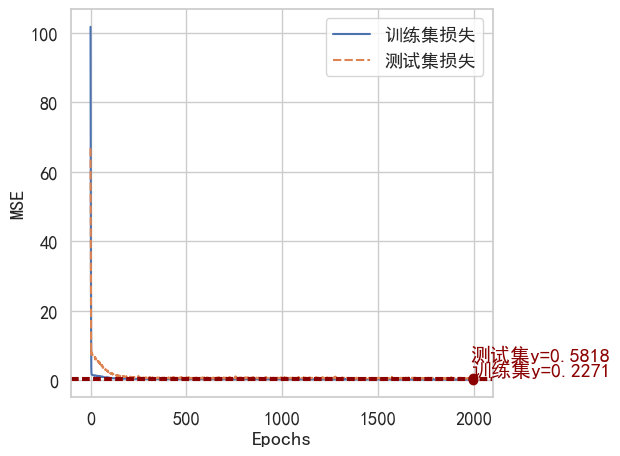

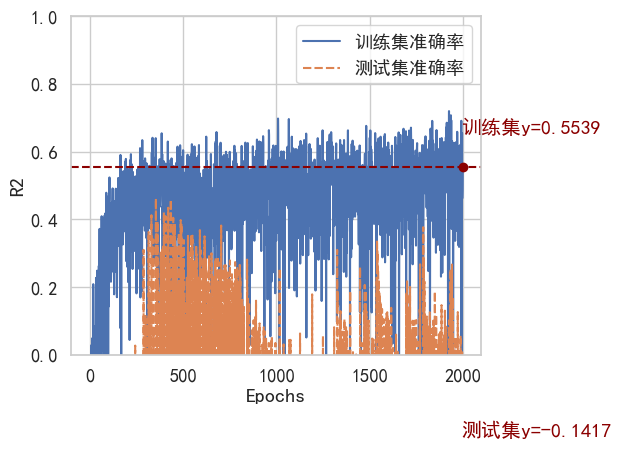

1/1 [==============================] - 0s 445ms/step


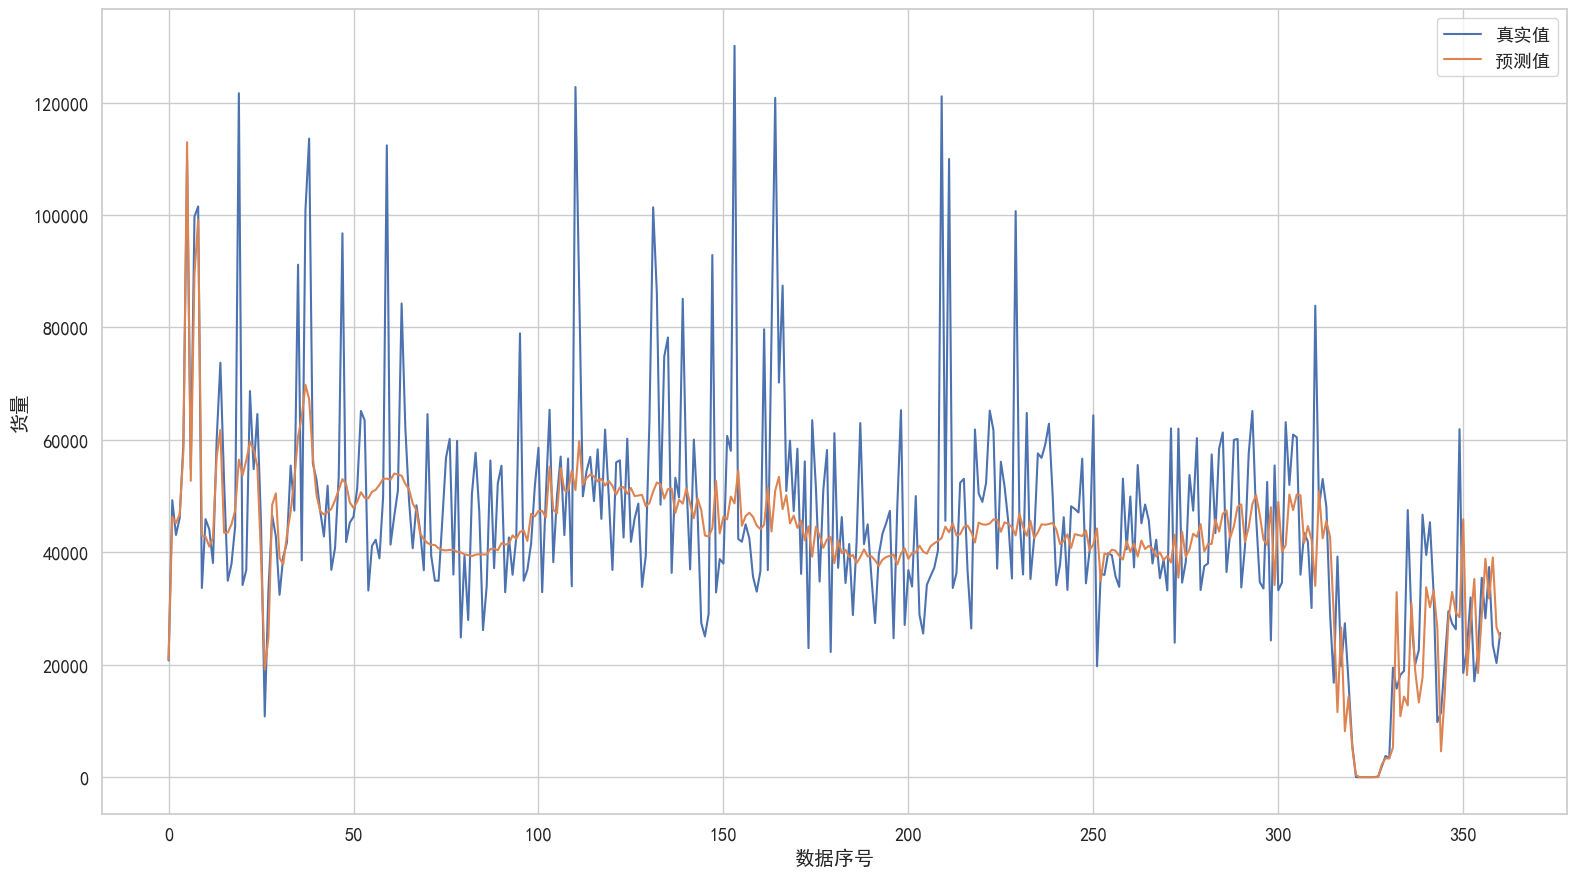

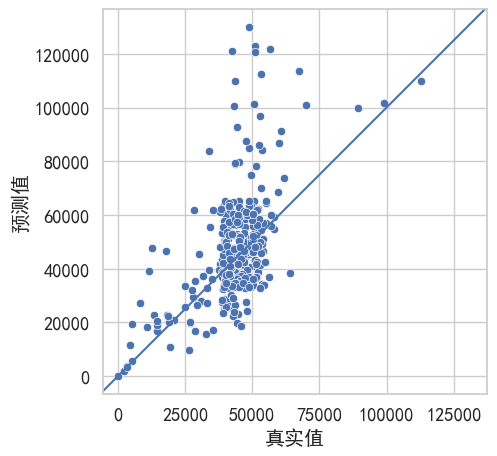

r2 0.3465599069692503
mse 286360259.78256136
mae 11313.963031115956
mape 0.5106618891306857


In [6]:

modelPath = 'LSTM.2022.single.h5'


# 定义自定义指标函数
def r_square(y_true, y_pred):
    SS_res = tf.keras.backend.sum(tf.keras.backend.square(y_true - y_pred))
    SS_tot = tf.keras.backend.sum(tf.keras.backend.square(y_true - tf.keras.backend.mean(y_true)))
    return (1 - SS_res / (SS_tot + tf.keras.backend.epsilon()))


if not os.path.exists(modelPath):
    # 定义和训练LSTM模型
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(128, input_shape=(look_back, trainX.shape[2])),
        tf.keras.layers.Dense(1)
    ])

    metrics = r_square
    metricsName = metrics.__name__
    model.compile(loss='mse', optimizer='adam', metrics=[metrics])
    # epochs=3000, batch_size=5000
    history = model.fit(trainX, trainY, validation_data=(testX, testY), epochs=2000)
    model.save(modelPath)

    # 绘制学习曲线
    loss = pd.DataFrame({'训练集损失': history.history['loss'], '测试集损失': history.history['val_loss'], })
    acc = pd.DataFrame(
        {'训练集准确率': history.history[metricsName], '测试集准确率': history.history[f'val_{metricsName}'], })

    sns.lineplot(loss)
    plt.xlabel('Epochs')
    plt.ylabel('MSE')
    # 绘制最后一个点并添加横线
    last_loss = history.history['loss'][-1]
    plt.plot(len(history.history['loss']) - 1, last_loss, marker='o', color='darkred')
    plt.axhline(y=last_loss, color='darkred', linestyle='--')
    # 添加红色直线的 y 值标签
    plt.text(len(loss) - 15, last_loss + 1, f'训练集y={last_loss:.4f}', color='darkred')
    # 绘制最后一个点并添加横线
    last_loss = history.history['val_loss'][-1]
    plt.plot(len(history.history['val_loss']) - 1, last_loss, marker='o', color='darkred')
    plt.axhline(y=last_loss, color='darkred', linestyle='--')
    # 添加红色直线的 y 值标签
    plt.text(len(loss) - 15, last_loss + 5, f'测试集y={last_loss:.4f}', color='darkred')
    plt.tight_layout()
    plt.savefig('损失率随训练代数的变化.svg')
    plt.show()

    sns.lineplot(acc)
    plt.xlabel('Epochs')
    plt.ylabel('R2')
    # 绘制最后一个点并添加横线
    last_acc = history.history[metricsName][-1]
    plt.plot(len(history.history[metricsName]) - 1, last_acc, marker='o', color='darkred')
    plt.axhline(y=last_acc, color='darkred', linestyle='--')
    # 添加红色直线的 y 值标签
    plt.text(len(acc) - 10, last_acc + 0.1, f'训练集y={last_acc:.4f}', color='darkred')
    # 绘制最后一个点并添加横线
    last_acc = history.history[f'val_{metricsName}'][-1]
    plt.plot(len(history.history[f'val_{metricsName}']) - 1, last_acc, marker='o', color='darkred')
    plt.axhline(y=last_acc, color='darkred', linestyle='--')
    # 添加红色直线的 y 值标签
    plt.text(len(acc) - 10, last_acc - 0.1, f'测试集y={last_acc:.4f}', color='darkred')
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.savefig('准确率随训练代数的变化.svg')
    plt.show()

else:
    # 加载模型并继续训练
    model = tf.keras.models.load_model(modelPath, custom_objects={'r_square': r_square})

# 测试模型
y_pred = model.predict(trainX, batch_size=500)

# 绘制预测结果和真实值的比较图
plt.figure(figsize=(16, 9))
plt.plot(np.exp(trainY), label='真实值')
plt.plot(np.exp(y_pred), label='预测值')
plt.ylabel('货量')
plt.xlabel('数据序号')
plt.legend()
plt.tight_layout()
plt.savefig('绘制预测结果和真实值的比较图.svg')
plt.show()

# y预测值-x真实值
sns.scatterplot({'预测值': np.exp(trainY), '真实值': np.exp(y_pred.reshape(len(y_pred)))}, x='真实值', y='预测值')
plt.axis('equal')
plt.axis('square')
_ = plt.plot([-1e10, 1e10], [-1e10, 1e10])
plt.tight_layout()
plt.savefig('y预测值-x真实值.svg')
plt.savefig('y预测值-x真实值.png')
plt.show()

print('r2', r2_score(np.exp(trainY), np.exp(y_pred)))
print('mse', mean_squared_error(np.exp(trainY), np.exp(y_pred)))
print('mae', mean_absolute_error(np.exp(trainY), np.exp(y_pred)))
print('mape', mean_absolute_percentage_error(np.exp(trainY), np.exp(y_pred)))

In [7]:
np.exp(trainY)

array([2.07520e+04, 4.92760e+04, 4.30970e+04, 4.60900e+04, 5.93340e+04,
       1.09910e+05, 5.47130e+04, 9.97490e+04, 1.01535e+05, 3.36590e+04,
       4.59020e+04, 4.40870e+04, 3.81030e+04, 6.00580e+04, 7.37290e+04,
       5.26720e+04, 3.49500e+04, 3.79110e+04, 4.46480e+04, 1.21671e+05,
       3.41940e+04, 3.68360e+04, 6.86830e+04, 5.48090e+04, 6.46080e+04,
       4.48450e+04, 1.08060e+04, 3.33580e+04, 4.65790e+04, 4.28350e+04,
       3.24470e+04, 3.92060e+04, 4.17710e+04, 5.54300e+04, 4.74170e+04,
       9.11740e+04, 3.85650e+04, 1.00867e+05, 1.13600e+05, 5.58440e+04,
       5.29010e+04, 4.73040e+04, 4.28220e+04, 5.18540e+04, 3.68790e+04,
       4.07580e+04, 5.35080e+04, 9.67540e+04, 4.18260e+04, 4.52980e+04,
       4.63350e+04, 5.14380e+04, 6.51540e+04, 6.34830e+04, 3.32020e+04,
       4.11700e+04, 4.22360e+04, 3.89350e+04, 4.98620e+04, 1.12403e+05,
       4.13710e+04, 4.63990e+04, 5.10160e+04, 8.42710e+04, 6.22230e+04,
       4.92360e+04, 4.07280e+04, 4.83720e+04, 4.38570e+04, 3.681